# GW2 ARIMA Modeling Notebook

This notebook combines the refreshed helpers in `ml.common.database` with a
simple ARIMA workflow. It demonstrates how to retrieve Guild Wars 2 trading
data, sanitize the rows without re-sorting by date, and run a baseline
forecast (including extended horizons) directly from the fetched order.


In [1]:
import os
from datetime import UTC, datetime
from pathlib import Path

from gw2ml import DatabaseClient, database


## Environment setup

1. Ensure a `.env` file (or environment) provides `DB_URL` with access to the
   production replica described in `docs/database/public_tables.md`.
2. Optionally set `NOTEBOOK_ITEM_ID` if you want to analyse a different item ID.
3. Run the cells below inside the managed `uv` environment (`uv run --project ml jupyter notebook`).


In [2]:
client = DatabaseClient.from_env()
ITEM_ID = int(os.getenv("NOTEBOOK_ITEM_ID", "19702"))
ITEM_ID


19702

## Prices: relative lookback

Fetch the last week of prices for the current item. The helper accepts
`last_days`, `last_hours`, or `last_minutes` and automatically normalises
results to UTC.


In [3]:
prices_last_week = database.get_prices(
    client,
    item_id=ITEM_ID,
    last_days=14,
    limit=600,
    order="DESC",
)
prices_last_week.head()


,id,item_id,whitelisted,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,fetched_at,created_at
0,849706037,19702,True,217152,160,765645,203,2025-11-28 18:55:40.815740+00:00,2025-11-28 18:55:40.815740+00:00
1,849678978,19702,True,217565,160,766030,200,2025-11-28 18:50:37.531085+00:00,2025-11-28 18:50:37.531085+00:00
2,849651719,19702,True,217618,160,767046,161,2025-11-28 18:45:56.343857+00:00,2025-11-28 18:45:56.343857+00:00
3,849623860,19702,True,217893,160,767077,199,2025-11-28 18:40:48.501813+00:00,2025-11-28 18:40:48.501813+00:00
4,849595201,19702,True,214315,159,766975,196,2025-11-28 18:35:44.636294+00:00,2025-11-28 18:35:44.636294+00:00


## Prices: explicit window

Supply timezone-aware start/end dates for a deterministic slice (mirrors
examples in `docs/database/prices_schema.md`).


In [62]:
custom_window_prices = database.get_prices(
    client,
    item_id=ITEM_ID,
    start_time=datetime(2025, 1, 1, tzinfo=UTC),
    end_time=datetime(2025, 1, 8, tzinfo=UTC),
    limit=500,
    order="DESC",
)
custom_window_prices.head()


,id,item_id,whitelisted,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,fetched_at,created_at


## BLTC history helpers

The BLTC table stores timestamps in seconds. The convenience wrapper handles
conversion and ordering automatically. Use `last_days` for quick pulls or
provide explicit `start_time` / `end_time` values.


In [63]:
bltc_last_three_days = database.get_bltc_history(
    client,
    item_id=ITEM_ID,
    last_days=3,
    limit=3000,
    order="DESC",
)
bltc_last_three_days.head()


,id,item_id,timestamp,sell_price,buy_price,supply,demand,sold,offers,bought,bids,created_at
0,49307673993,19702,2025-11-20 12:56:39+00:00,172,167,693003,251718,1383,0,133,0,2025-11-20 13:05:17.091884+00:00
1,49307673992,19702,2025-11-20 12:49:12+00:00,172,167,694387,251851,172,0,258,0,2025-11-20 13:05:17.091884+00:00
2,49307673991,19702,2025-11-20 12:41:16+00:00,172,167,694559,252109,671,0,0,154,2025-11-20 13:05:17.091884+00:00
3,49307673990,19702,2025-11-20 12:34:04+00:00,170,167,694972,251955,576,0,159,0,2025-11-20 13:05:17.091884+00:00
4,49307673989,19702,2025-11-20 12:26:03+00:00,170,167,695508,252114,0,1167,364,0,2025-11-20 13:05:17.091884+00:00


## Simple ARIMA walk-through


In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

DEFAULT_VALUE_COLUMN = "buy_unit_price"


def build_series(df: pd.DataFrame, value_column: str = DEFAULT_VALUE_COLUMN) -> np.ndarray:
    """Return a dense numeric series using the incoming row order only."""
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not available in frame: {df.columns.tolist()}")
    usable = df[value_column].dropna().astype(float).reset_index(drop=True)
    if usable.empty:
        raise ValueError("No usable rows remaining after dropping null observations.")
    return usable.to_numpy()


In [65]:
def train_arima_model(series_values: np.ndarray, order: tuple[int, int, int]) -> ARIMAResults:
    """Fit an ARIMA model for the provided numeric series."""
    if len(series_values) == 0:
        raise ValueError("Training series is empty – provide at least one observation.")
    model = ARIMA(series_values, order=order)
    return model.fit()


def forecast_with_model(model_results: ARIMAResults, steps: int) -> np.ndarray:
    """Generate a forecast for the requested number of steps."""
    if steps <= 0:
        raise ValueError("Forecast steps must be greater than zero.")
    return model_results.forecast(steps=steps)


def perform_backtest(
    series_values: np.ndarray,
    window_size: int,
    horizon: int,
    order: tuple[int, int, int],
) -> pd.DataFrame:
    """Rolling-origin backtest that refits ARIMA for each window."""
    if window_size <= 0:
        raise ValueError("window_size must be greater than zero.")
    if horizon <= 0:
        raise ValueError("horizon must be greater than zero.")
    if len(series_values) < window_size + horizon:
        raise ValueError(
            "Not enough observations for the requested window_size and horizon."
        )

    rows: list[dict[str, float | int]] = []
    last_start = len(series_values) - window_size - horizon
    for start_idx in range(0, last_start + 1):
        window_slice = series_values[start_idx : start_idx + window_size]
        model_results = train_arima_model(window_slice, order)
        forecast_values = forecast_with_model(model_results, horizon)
        actual_slice = series_values[
            start_idx + window_size : start_idx + window_size + horizon
        ]
        for step_idx, (actual_value, predicted_value) in enumerate(
            zip(actual_slice, forecast_values, strict=True),
            start=1,
        ):
            rows.append(
                {
                    "window_id": start_idx,
                    "step": step_idx,
                    "actual": float(actual_value),
                    "prediction": float(predicted_value),
                    "absolute_error": float(abs(actual_value - predicted_value)),
                }
            )

    return pd.DataFrame(rows)



In [66]:
VALUE_COLUMN = "buy_unit_price"
series = build_series(prices_last_week, VALUE_COLUMN)

split_idx = max(1, int(len(series) * 0.8))
train_series = series[:split_idx]
test_series = series[split_idx:]

print(f"Total points: {len(series)} | Train: {len(train_series)} | Test: {len(test_series)}")


Total points: 600 | Train: 480 | Test: 120


## Model usage with held-out test data

Leverage the helper utilities to fit an ARIMA model on the training slice,
forecast the reserved samples, and summarise accuracy before promoting a
configuration.



In [67]:
MODEL_ORDER = (1, 1, 1)
FORECAST_EXTRA_STEPS = 60

if len(test_series) == 0:
    raise ValueError("Test series is empty – ensure you pulled enough rows before fitting the model.")

fitted_model = train_arima_model(train_series, MODEL_ORDER)
forecast_steps = len(test_series) + FORECAST_EXTRA_STEPS
full_forecast = forecast_with_model(fitted_model, forecast_steps)
test_forecast = full_forecast[: len(test_series)]
future_forecast = full_forecast[len(test_series) :]
test_mape = mean_absolute_percentage_error(test_series, test_forecast)
test_mae = mean_absolute_error(test_series, test_forecast)

test_comparison = pd.DataFrame(
    {
        "actual": test_series,
        "prediction": test_forecast,
        "absolute_error": np.abs(test_series - test_forecast),
    }
)

globals()["forecast"] = test_forecast
globals()["future_forecast"] = future_forecast
globals()["arima_order"] = MODEL_ORDER

print(
    "Held-out test metrics -> "
    f"MAPE: {test_mape:.3%}, "
    f"MAE: {test_mae:.3f}"
)

test_comparison.head(10)


Held-out test metrics -> MAPE: 3.413%, MAE: 6.269


,actual,prediction,absolute_error
0,190.0,190.272916,0.272916
1,190.0,190.420305,0.420305
2,187.0,190.499904,3.499904
3,186.0,190.542892,4.542892
4,186.0,190.566108,4.566108
5,187.0,190.578646,3.578646
6,186.0,190.585417,4.585417
7,187.0,190.589074,3.589074
8,186.0,190.591049,4.591049
9,186.0,190.592116,4.592116


### Visual diagnostics


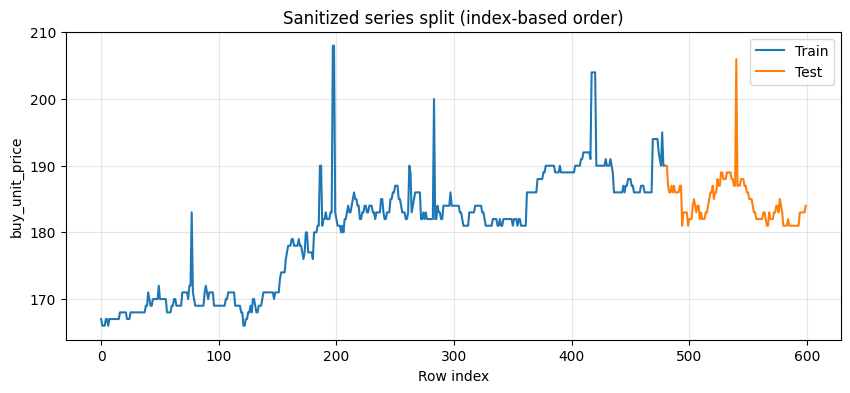

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(train_series)), train_series, label="Train", color="tab:blue")
ax.plot(
    range(len(train_series), len(series)),
    test_series,
    label="Test",
    color="tab:orange",
)
ax.set_title("Sanitized series split (index-based order)")
ax.set_xlabel("Row index")
ax.set_ylabel(VALUE_COLUMN)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


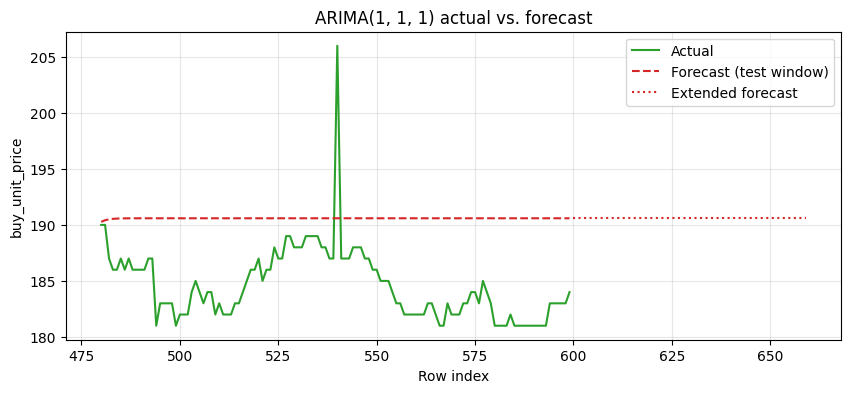

In [69]:
plot_forecast = globals().get("forecast")
plot_future = globals().get("future_forecast")
plot_order = globals().get("arima_order")

if plot_forecast is None or plot_future is None:
    plot_order = plot_order or (1, 1, 1)
    print("Forecast not found; fitting ARIMA for plotting.")
    _plot_model = ARIMA(train_series, order=plot_order)
    _plot_model_fit = _plot_model.fit()
    _full_forecast = _plot_model_fit.forecast(steps=len(test_series) + 60)
    plot_forecast = _full_forecast[: len(test_series)]
    plot_future = _full_forecast[len(test_series) :]
    globals()["forecast"] = plot_forecast
    globals()["future_forecast"] = plot_future
    globals()["arima_order"] = plot_order

comparison_index = np.arange(len(train_series), len(series))
future_index = np.arange(len(series), len(series) + len(plot_future))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(comparison_index, test_series, label="Actual", color="tab:green")
ax.plot(
    comparison_index,
    plot_forecast,
    label="Forecast (test window)",
    color="tab:red",
    linestyle="--",
)
if len(plot_future) > 0:
    ax.plot(
        future_index,
        plot_future,
        label="Extended forecast",
        color="tab:red",
        linestyle=":",
    )
ax.set_title(f"ARIMA{plot_order} actual vs. forecast")
ax.set_xlabel("Row index")
ax.set_ylabel(VALUE_COLUMN)
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()


## Rolling-origin backtesting

Walk a sliding training window across the full series, refit ARIMA for each
window, and inspect short-horizon forecasts to ensure the configuration stays
stable beyond a single train/test split.



In [70]:
BACKTEST_WINDOW_SIZE = 200
BACKTEST_HORIZON = 5

backtest_results = perform_backtest(
    series_values=series,
    window_size=BACKTEST_WINDOW_SIZE,
    horizon=BACKTEST_HORIZON,
    order=MODEL_ORDER,
)

if backtest_results.empty:
    raise ValueError("Backtest returned no rows – adjust the window or horizon.")

aggregate_backtest_mape = mean_absolute_percentage_error(
    backtest_results["actual"], backtest_results["prediction"]
)
aggregate_backtest_mae = mean_absolute_error(
    backtest_results["actual"], backtest_results["prediction"]
)
mean_abs_error_per_window = (
    backtest_results.groupby("window_id")["absolute_error"].mean().rename("mean_abs_error")
)

print(
    "Backtest summary -> "
    f"windows: {backtest_results['window_id'].nunique()}, "
    f"evaluations: {len(backtest_results)}, "
    f"MAPE: {aggregate_backtest_mape:.3%}, "
    f"MAE: {aggregate_backtest_mae:.3f}"
)

backtest_results.assign(
    mean_abs_error=backtest_results["window_id"].map(mean_abs_error_per_window)
).head(10)


Backtest summary -> windows: 396, evaluations: 1980, MAPE: 0.934%, MAE: 1.755


,window_id,step,actual,prediction,absolute_error,mean_abs_error
0,0,1,182.0,185.795996,3.795996,6.218297
1,0,2,181.0,187.024452,6.024452,6.218297
2,0,3,181.0,187.564189,6.564189,6.218297
3,0,4,181.0,187.801330,6.801330,6.218297
4,0,5,180.0,187.905520,7.905520,6.218297
5,1,1,181.0,184.351466,3.351466,4.902620
6,1,2,181.0,185.476799,4.476799,4.902620
7,1,3,181.0,186.015345,5.015345,4.902620
8,1,4,180.0,186.273076,6.273076,4.902620
9,1,5,181.0,186.396417,5.396417,4.902620


In [71]:
bltc_custom_range = database.get_bltc_history(
    client,
    item_id=ITEM_ID,
    start_time=datetime(2025, 2, 1, tzinfo=UTC),
    end_time=datetime(2025, 2, 7, tzinfo=UTC),
    limit=5000,
    order="DESC",
)
bltc_custom_range.head()


,id,item_id,timestamp,sell_price,buy_price,supply,demand,sold,offers,bought,bids,created_at
0,165199915,19702,2025-02-07 00:00:00+00:00,181,158,533962,194860,13552,13715,7847,10062,2025-07-29 21:19:17.132938+00:00
1,165199914,19702,2025-02-06 18:00:00+00:00,186,158,535824,192752,10504,11749,7311,6185,2025-07-29 21:19:17.132938+00:00
2,165199913,19702,2025-02-06 12:00:00+00:00,187,169,536613,193129,8660,14978,6891,11243,2025-07-29 21:19:17.132938+00:00
3,165199912,19702,2025-02-06 06:00:00+00:00,180,155,528802,188777,9636,14471,9251,5322,2025-07-29 21:19:17.132938+00:00
4,165199911,19702,2025-02-06 00:00:00+00:00,191,164,524599,192706,15497,8918,11540,15129,2025-07-29 21:19:17.132938+00:00


## TP history helpers

`get_tp_history` mirrors the timed access patterns but honours the millisecond
precision used in `gw2tp_historical_prices`.


In [72]:
tp_last_hours = database.get_tp_history(
    client,
    item_id=ITEM_ID,
    last_hours=12,
    limit=4000,
    order="DESC",
)
tp_last_hours.head()


,id,item_id,timestamp,sell_price,buy_price,supply,demand,created_at
0,48451096452,19702,2025-11-20 09:41:40+00:00,172,170,689614,257642,2025-11-20 09:43:25.592769+00:00
1,48451096451,19702,2025-11-20 09:36:44+00:00,194,171,689754,257322,2025-11-20 09:43:25.592769+00:00
2,48451096450,19702,2025-11-20 09:31:41+00:00,186,170,690081,257274,2025-11-20 09:43:25.592769+00:00
3,48451096449,19702,2025-11-20 09:26:45+00:00,185,170,690451,257305,2025-11-20 09:43:25.592769+00:00
4,48451096448,19702,2025-11-20 09:21:45+00:00,185,170,690732,257586,2025-11-20 09:43:25.592769+00:00


In [73]:
tp_custom_range = database.get_tp_history(
    client,
    item_id=ITEM_ID,
    start_time=datetime(2025, 3, 1, tzinfo=UTC),
    end_time=datetime(2025, 3, 5, tzinfo=UTC),
    limit=5000,
    order="DESC",
)
tp_custom_range.head()


,id,item_id,timestamp,sell_price,buy_price,supply,demand,created_at
0,124190883,19702,2025-03-04 08:33:53+00:00,208,174,542344,218288,2025-07-29 18:51:00.335576+00:00
1,124190882,19702,2025-03-04 02:49:15+00:00,202,169,546722,213411,2025-07-29 18:51:00.335576+00:00
2,124190881,19702,2025-03-03 08:18:27+00:00,204,157,545060,201775,2025-07-29 18:51:00.335576+00:00
3,124190880,19702,2025-03-02 19:43:10+00:00,200,162,547210,206938,2025-07-29 18:51:00.335576+00:00
4,124190879,19702,2025-03-02 08:58:34+00:00,198,161,555564,210778,2025-07-29 18:51:00.335576+00:00


## Optional exports

Everything returned is a `pandas.DataFrame`. Use your preferred persistence or
analysis pattern—e.g. writing to `data/tests/` for reproducible snapshots.


## Normalize rows without date ordering

To keep the fetched order intact while eliminating any null-only rows, we sanitize every DataFrame below. This intentionally avoids re-sorting on datetime columns so downstream analyses operate strictly on the raw retrieval order.


In [74]:
def sanitize_frame(df):
    """Drop null-only rows and preserve the original ordering."""
    return df.dropna(how="all").reset_index(drop=True)

prices_last_week = sanitize_frame(prices_last_week)
custom_window_prices = sanitize_frame(custom_window_prices)
bltc_last_three_days = sanitize_frame(bltc_last_three_days)
bltc_custom_range = sanitize_frame(bltc_custom_range)
tp_last_hours = sanitize_frame(tp_last_hours)
tp_custom_range = sanitize_frame(tp_custom_range)

prices_last_week.head()


,id,item_id,whitelisted,buy_quantity,buy_unit_price,sell_quantity,sell_unit_price,fetched_at,created_at
0,784243311,19702,True,253226,167,692210,170,2025-11-20 13:45:39.179407+00:00,2025-11-20 13:45:39.179407+00:00
1,784215715,19702,True,252806,166,692457,169,2025-11-20 13:41:00.456264+00:00,2025-11-20 13:41:00.456264+00:00
2,784187919,19702,True,251183,166,692207,170,2025-11-20 13:35:39.585566+00:00,2025-11-20 13:35:39.585566+00:00
3,784159923,19702,True,251350,166,692314,170,2025-11-20 13:30:39.067690+00:00,2025-11-20 13:30:39.067690+00:00
4,784132327,19702,True,251411,167,691848,170,2025-11-20 13:25:38.407380+00:00,2025-11-20 13:25:38.407380+00:00


In [75]:
export_dir = Path("../data/tests").resolve()
export_dir.mkdir(parents=True, exist_ok=True)
(prices_last_week
 .to_csv(export_dir / "notebook_prices_last_week.csv", index=False))
